# Assignment 1: Interpretability

We will work on the model interpretability. First, we will implement LIME (Local interpretable model-agnostic explanations) and then explore SHAP (SHapley Additive exPlanations). Information about SHAP can be found [here](https://arxiv.org/abs/1705.07874).


## 1. Implement and Test LIME


We will implement LIME using the information from the lecture and the publication. We will rely on the Inception V3 neural network. In addition, the focus would be on analysing the top 1 and top 2 predictions. The focus are images for this assignment. Superpixels are allowed to be used for making the task easier.
Note that you should not use an available LIME python-based library.

The test image are the following Wikipedia entries:
[Image 1](https://commons.wikimedia.org/wiki/File:Schloss-Erlangen02.JPG)
[Image 2](https://commons.wikimedia.org/wiki/File:Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG)
[Image 3](https://commons.wikimedia.org/wiki/File:Alte-universitaets-bibliothek_universitaet-erlangen.jpg)

In [2]:
%matplotlib inline 
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.segmentation import quickshift
from skimage import io, img_as_float, transform

import torch.nn.functional as F

from PIL import Image
import requests
from io import BytesIO
import requests


images_test = ['Schloss-Erlangen02.jpeg', 'imag3.jpg', 'imag2.jpeg']

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

imgs_tensor_array = []
model = torchvision.models.inception_v3(pretrained=True)
model.eval()
imagenet_classes = requests.get("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt").text.splitlines()
top_catids = []
top_probs = []
images = []
for i,img_test in enumerate(images_test):
    
    img = Image.open(img_test)
    images.append(img)

    img_tensor = preprocess(img).unsqueeze(0) # Add a batch dimension (Inception expects batches)



    with torch.no_grad():
        output =  model(img_tensor)
        probabilities = F.softmax(output[0], dim=0)



    top2_prob, top2_catid = torch.topk(probabilities, 2)     
    top_catids.append(top2_catid)
    top_probs.append(top2_prob)

print('Prediction finished')




Prediction finished


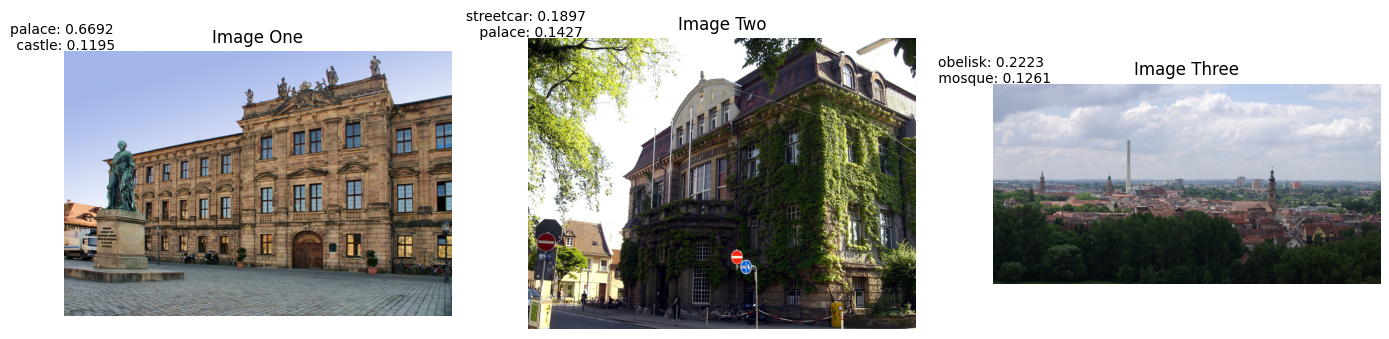

In [3]:
# Titles
title1 = "Image One"
title2 = "Image Two"
title3 = "Image Three"

# Short descriptions
description1 = f"{imagenet_classes[top_catids[0][0]]}: {top_probs[0][0]:.4f} \n {imagenet_classes[top_catids[0][1]]}: {top_probs[0][1]:.4f}"
description2 = f"{imagenet_classes[top_catids[1][0]]}: {top_probs[1][0]:.4f} \n {imagenet_classes[top_catids[1][1]]}: {top_probs[1][1]:.4f}"
description3 = f"{imagenet_classes[top_catids[2][0]]}: {top_probs[2][0]:.4f} \n {imagenet_classes[top_catids[2][1]]}: {top_probs[2][1]:.4f}"

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 8))

# Plot image 1
axes[0].imshow(images[0], cmap='viridis')
axes[0].set_title(title1)
axes[0].axis('off')
axes[0].text(0.5, -10, description1, ha='center') 
#axes[0].text(0.5, -10, description1_2, ha='center') # Adjust y-value for position

# Plot image 2
axes[1].imshow(images[1], cmap='gray')
axes[1].set_title(title2)
axes[1].axis('off')
axes[1].text(0.5, -10, description2, ha='center') 

# Plot image 3
axes[2].imshow(images[2], cmap='plasma')
axes[2].set_title(title3)
axes[2].axis('off')
axes[2].text(0.5, -10, description3, ha='center') 


plt.tight_layout()

# Show the plot
plt.show()


Superpixel generation complete.


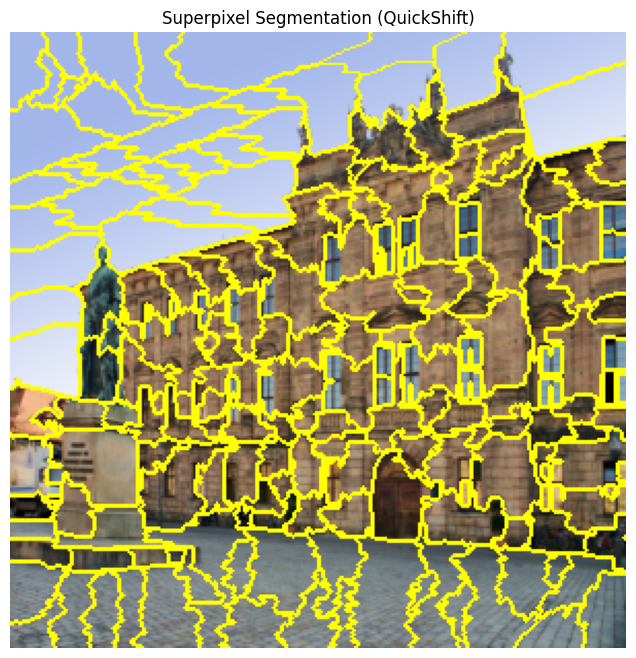

Number of superpixels identified: 193
Superpixel generation complete.


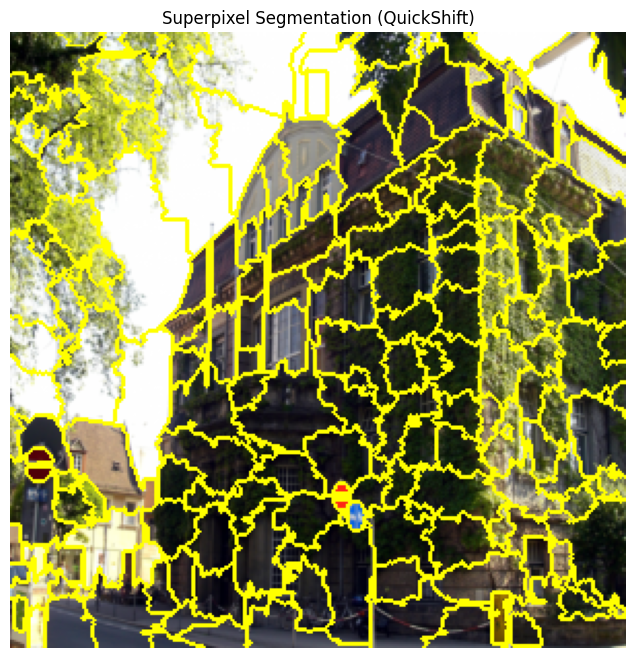

Number of superpixels identified: 197
Superpixel generation complete.


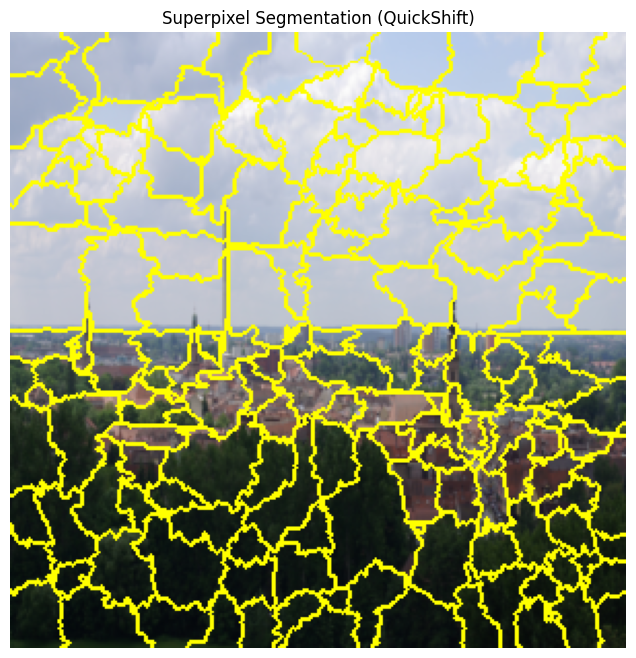

Number of superpixels identified: 171


In [4]:
#Super Pixels
from skimage.segmentation import mark_boundaries
from numpy import asarray

img_SP_list = []
superpixel_ids_list = []
num_superpixels_list = []
image_resized_list = []

for i,img_test in enumerate(images_test):
    
    img_array = io.imread(img_test)
    image_resized = transform.resize(img_array, (299, 299), anti_aliasing=True)
    
    
    img_SP = quickshift(
        image_resized,
        kernel_size=4,  
        max_dist=6,     
        ratio=0.2       
    )
    img_SP = img_SP.astype(int)
    
    print("Superpixel generation complete.")
    
    # Display the superpixel segmentation
    # mark_boundaries overlays the superpixel boundaries on the original image
    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(image_resized, img_SP))
    plt.title("Superpixel Segmentation (QuickShift)")
    plt.axis('off')
    plt.show()
    
    
    # Get the unique superpixel IDs
    superpixel_ids = np.unique(img_SP)
    
    # Get the total number of superpixels
    num_superpixels = len(superpixel_ids)
    
    print(f"Number of superpixels identified: {num_superpixels}")

    img_SP_list.append(img_SP)
    superpixel_ids_list.append(superpixel_ids)
    num_superpixels_list.append(num_superpixels)
    image_resized_list.append(image_resized)
    

In [5]:
# --- Step 5: Perturbation Loop ---

NUM_SAMPLES = 300
SUPERPIXEL_RATIO = 0.2

perturbed_images_massive_list = []
binary_perturbations_massive_list = []
binary_perturbations_np_list = []


for j,image_resized in enumerate(image_resized_list):

    perturbed_images_list = []
    binary_perturbations_list = []
    superpixel_id_to_idx = {sp_id: idx for idx, sp_id in enumerate(superpixel_ids_list[j])}
    
    for i in range(NUM_SAMPLES):
        binary_vector = np.ones(num_superpixels_list[j], dtype=int)
    
        num_off = int(SUPERPIXEL_RATIO * num_superpixels_list[j])
        if num_off >= num_superpixels_list[j]:
            num_off = num_superpixels_list[j] - 1 if num_superpixels_list[j] > 1 else 0
    
        off_idxs = np.random.choice(num_superpixels_list[j], num_off, replace=False)
        binary_vector[off_idxs] = 0
        binary_perturbations_list.append(binary_vector)
    
        # Create perturbed image
        perturbed_image = image_resized.copy()
        mask_keep = np.zeros(image_resized.shape[:2], dtype=bool)
    
        for sp_id in superpixel_ids_list[j]:
            idx = superpixel_id_to_idx[sp_id]
            if binary_vector[idx] == 1:
                mask_keep[img_SP_list[j] == sp_id] = True

        NEUTRAL_COLOR = np.mean(image_resized_list[j], axis=(0, 1))  # (R, G, B)
        perturbed_image[~mask_keep] = NEUTRAL_COLOR
    
        # Convert and preprocess
        try:
            perturbed_img_pil = Image.fromarray((perturbed_image * 255).astype(np.uint8))
            perturbed_img_tensor = preprocess(perturbed_img_pil).unsqueeze(0)
            perturbed_images_list.append(perturbed_img_tensor)
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
    
    # --- Final Output ---
    binary_perturbations_np = np.array(binary_perturbations_list)
    print(f"Generated {len(perturbed_images_list)} perturbed samples for image {j} .")
    perturbed_images_massive_list.append(perturbed_images_list)
    binary_perturbations_massive_list.append(binary_perturbations_list)
    binary_perturbations_np_list.append(binary_perturbations_np)

Generated 300 perturbed samples for image 0 .
Generated 300 perturbed samples for image 1 .
Generated 300 perturbed samples for image 2 .


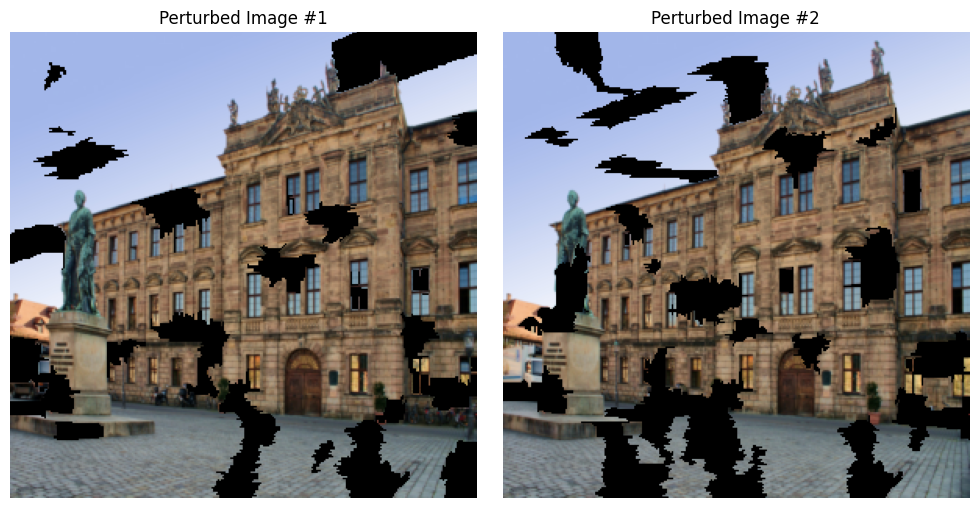

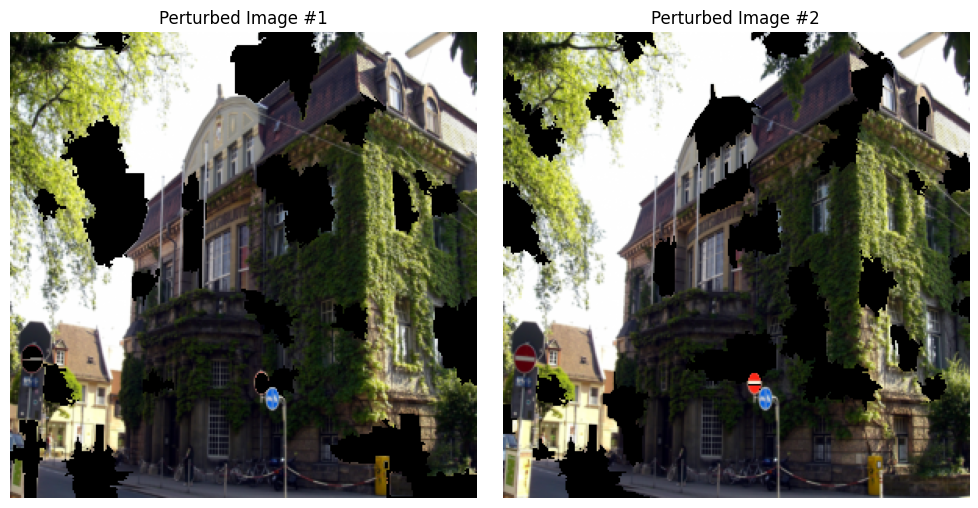

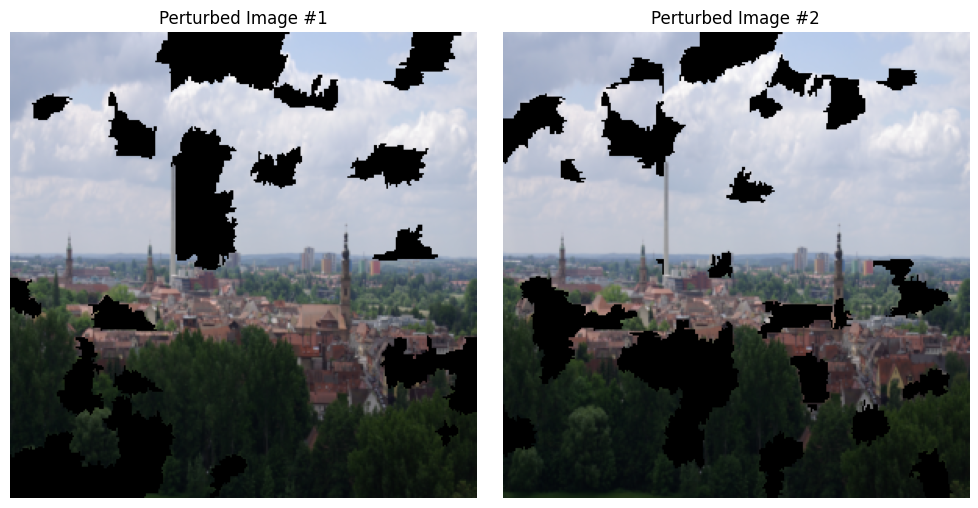

In [6]:


for j, bin_perturb_list in enumerate(binary_perturbations_massive_list):
    

    # Display 4 perturbed images using matplotlib
    superpixel_id_to_idx = {sp_id: idx for idx, sp_id in enumerate(superpixel_ids_list[j])}
    plt.figure(figsize=(10, 10))
    for i in range(2):
        # Retrieve the binary vector to show which superpixels are active
        binary_vector = bin_perturb_list[i]
    
        # Reconstruct the perturbed image (again, just for display)
        perturbed_image = image_resized_list[j].copy()
        mask_keep = np.zeros(image_resized_list[j].shape[:2], dtype=bool)
    
        for sp_id in superpixel_ids_list[j]:
            idx = superpixel_id_to_idx[sp_id]
            if binary_vector[idx] == 1:
                mask_keep[img_SP_list[j] == sp_id] = True
    
        #perturbed_image[~mask_keep] = NEUTRAL_COLOR
        perturbed_image[~mask_keep] = 0
    
        # Plot
        plt.subplot(2, 2, i + 1)
        plt.imshow(perturbed_image)
        plt.title(f"Perturbed Image #{i + 1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [7]:
## Perturbed predictions


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

perturbed_predictions_list = []

for i, perturbed_img in enumerate(perturbed_images_massive_list):
    

    perturbed_batch = torch.cat(perturbed_img, dim=0)
    

    
    # Move batch to device
    perturbed_batch = perturbed_batch.to(device)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(perturbed_batch)  # Shape: [N, num_classes]
        probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Shape: [N, num_classes]
    
    # Extract top-1 and top-2 class probabilities
    perturbed_predictions = probabilities[:, [top_catids[i][0], top_catids[i][1]]].cpu().tolist()
    # Now perturbed_predictions is a list of [prob_top1, prob_top2] for each image

    perturbed_predictions_list.append(perturbed_predictions)
    print(f"Predictions for {len(perturbed_predictions)} perturbed samples stored.")


Predictions for 300 perturbed samples stored.
Predictions for 300 perturbed samples stored.
Predictions for 300 perturbed samples stored.


In [8]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.linear_model import Ridge


coefs_list = []

for i, bin_pert_np in enumerate(binary_perturbations_np_list):
    

    # Distance from each binary vector to the original (which is all-ones)
    original_vector = np.ones((1, bin_pert_np.shape[1]))
    distances = cosine_distances(bin_pert_np, original_vector)[:, 0]
    
    # Kernel width (tune as needed; larger values = more smoothing)
    kernel_width = 0.25
    weights = np.exp(-distances ** 2 / kernel_width ** 2)
    
    
    
    # y: target values = probability for top1 class
    y = np.array([pred[0] for pred in perturbed_predictions])  # Assuming top1 class is at index 0
    X = bin_pert_np
    
    # Fit Ridge regression (L2 regularized linear model)
    local_model = Ridge(alpha=1.0)
    local_model.fit(X, y, sample_weight=weights)
    coefs_list.append(local_model.coef_)
    print("Model trained")

Model trained
Model trained
Model trained


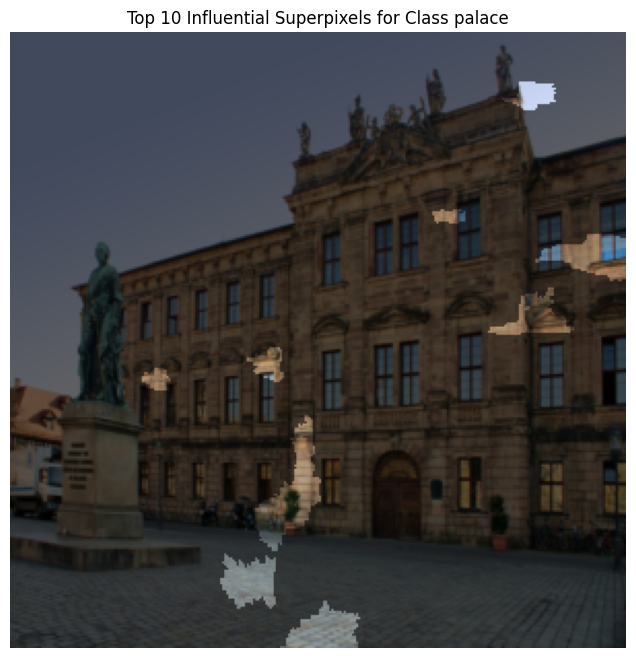

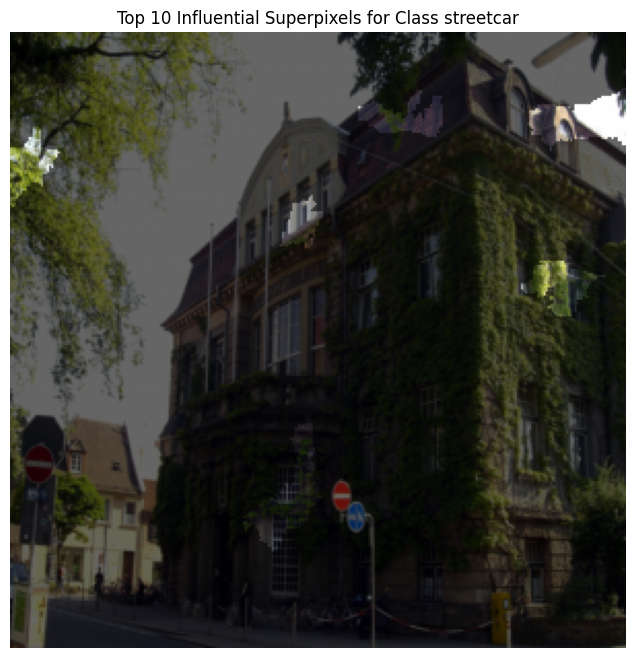

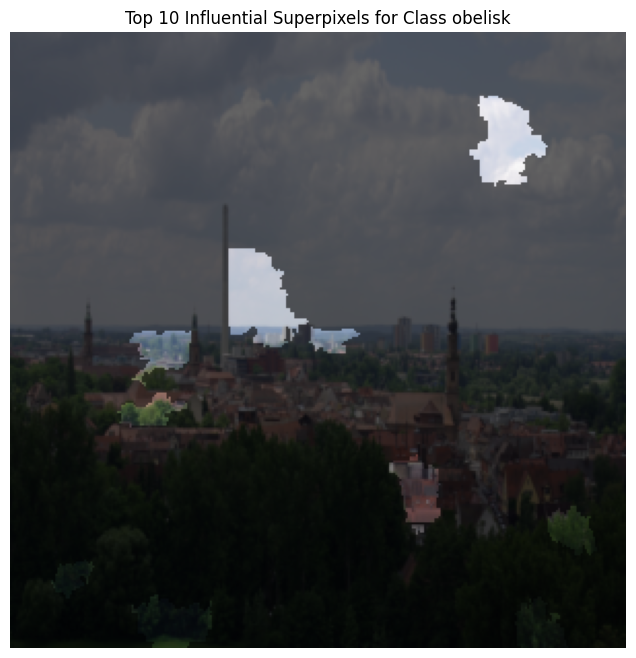

In [9]:



# Number of superpixels to highlight
NUM_TOP_FEATURES = 10


for i, coefs in enumerate(coefs_list):
    
# Get the top influential superpixels (absolute coefficient value)
    superpixel_id_to_idx = {sp_id: idx for idx, sp_id in enumerate(superpixel_ids_list[i])}
    top_k_indices = np.argsort(np.abs(coefs))[-NUM_TOP_FEATURES:]  # Indices of most influential superpixels
    
    # Build a mask for those superpixels
    highlight_mask = np.zeros(img_SP_list[i].shape, dtype=bool)
    for sp_id in superpixel_ids_list[i]:
        idx = superpixel_id_to_idx[sp_id]
        if idx in top_k_indices:
            highlight_mask[img_SP_list[j] == sp_id] = True
    
    # Create a masked version of the original image
    highlighted_image = image_resized_list[i].copy()
    # Dim out everything else by blending with neutral color
    alpha = 0.4
    highlighted_image[~highlight_mask] = (
        alpha * highlighted_image[~highlight_mask] + (1 - alpha) * 0 ##NEUTRAL_COLOR
    )
    
    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(highlighted_image)
    plt.title(f"Top {NUM_TOP_FEATURES} Influential Superpixels for Class {imagenet_classes[top_catids[i][0]]}")
    plt.axis('off')
    plt.show()


## 2. Test SHAP

For the same images, you should now use the SHAP algorithm to provide visual explanations. In this case, you do not need to implement the algorithm. Instead, you could use an existing Python library such as [SHAP](https://shap.readthedocs.io/en/latest/image_examples.html). ResNet 50 is a good reference for running the tests. Inception V3 can also be used. For this task, [TensorFlow](https://www.tensorflow.org) can be used as well.

The test image are the following Wikipedia entries:
[Image 1](https://commons.wikimedia.org/wiki/File:Schloss-Erlangen02.JPG)
[Image 2](https://commons.wikimedia.org/wiki/File:Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG)
[Image 3](https://commons.wikimedia.org/wiki/File:Alte-universitaets-bibliothek_universitaet-erlangen.jpg)

![](https://shap.readthedocs.io/en/latest/_images/example_notebooks_image_examples_image_classification_Explain_ResNet50_using_the_Partition_explainer_10_0.png)

In [10]:
from torchvision.models import resnet50, ResNet50_Weights
import shap


weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights= weights)
#model = resnet50(pretrained = True)
categories = weights.meta["categories"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print("number of classes: ", len(categories))

number of classes:  1000


In [11]:
#X, y = shap.datasets.imagenet50()
from skimage.transform import resize

test1 = np.array(images[0])
test2 = np.array(images[1])
test3 = np.array(images[2])



resized1 = resize(test1, (224, 224), anti_aliasing=True)
resized2 = resize(test2, (224, 224), anti_aliasing=True)
resized3 = resize(test3, (224, 224), anti_aliasing=True)

X = np.stack([resized1, resized2, resized3], axis=0)

In [12]:
# Prepare data transformation pipeline

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform = [
    #torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

In [13]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    #print(output)
    return output

In [14]:
Xtr = transform(torch.Tensor(X))
#print(Xtr.shape)
out = predict(Xtr[0:3])
classes = torch.argmax(out, axis=1).cpu().numpy()
print(f"Classes: {classes}: {np.array(categories)[classes]}")

Classes: [663 601 644]: ['monastery' 'hoopskirt' 'matchstick']


In [15]:
topk = 4
batch_size = 50
n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=categories)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    Xtr[0:1],
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:41, 41.17s/it]                                                                                      


In [16]:
(shap_values.data.shape, shap_values.values.shape)

(torch.Size([1, 224, 224, 3]), (1, 224, 224, 3, 4))

In [17]:
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

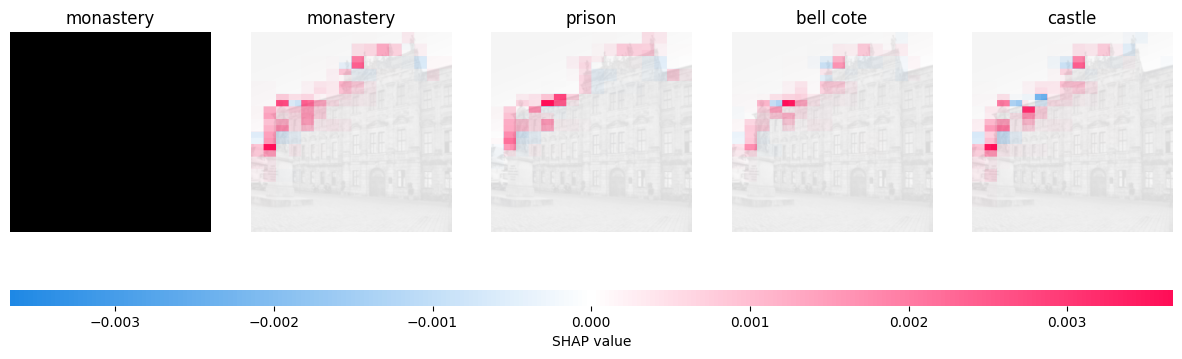

In [18]:
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[categories[663]],
)